# creating runlist

In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import yaml
import os
import matplotlib.pyplot as plt

from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.data import DataStore
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.irf import Background3D

import warnings
warnings.filterwarnings('ignore')

In [8]:
# loading general parameters
hessera = 'hess2'
source_catalog = "Crab Nebula"

with open("/home/vault/caph/mppi062h/repositories/syserror_3d_bkgmodel/general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
zen_bins=cfg['zen_bins']

In [9]:
basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
obs_table = ds.obs_table

# run selection
mask_source = obs_table['OBJECT'] == source_catalog
mask_tel = obs_table['N_TELS'] == cfg['mask_ntels']
mask_zenpnt = obs_table['ZEN_PNT'] < cfg['mask_zenpnt']
mask_eventcount = obs_table['EVENT_COUNT'] > cfg['mask_eventcount']
mask_ontime = obs_table['ONTIME'] > cfg['mask_ontime']
mask_final = mask_source & mask_tel & mask_zenpnt & mask_eventcount & mask_ontime 
runlist = np.asarray(obs_table['OBS_ID'][mask_final])

In [10]:
np.savetxt(f'crab_runlist_{hessera}.txt', runlist)

# checking the runs

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import yaml

from gammapy.data import DataStore

import datetime
import matplotlib.dates as mdates

In [2]:
hesseras = ['hess1', 'hess2', 'hess1u']
with open("/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']


full_info = []
for hessera in hesseras:
    runlist= np.loadtxt(f'crab_runlist_{hessera}.txt')
    
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    obs_table = ds.obs_table

    mask = [True if obsid in runlist else False for obsid in obs_table['OBS_ID']]
    obs_table=obs_table[mask]
    
    full_info.append(obs_table)

In [3]:
day = '27'
month = '10'
time_label=['2008-2010', '2010-2012', '2012-2014', '2014-2016', '2016-2018', '2018-2020', '2020-2022']
N_bin_met = 8

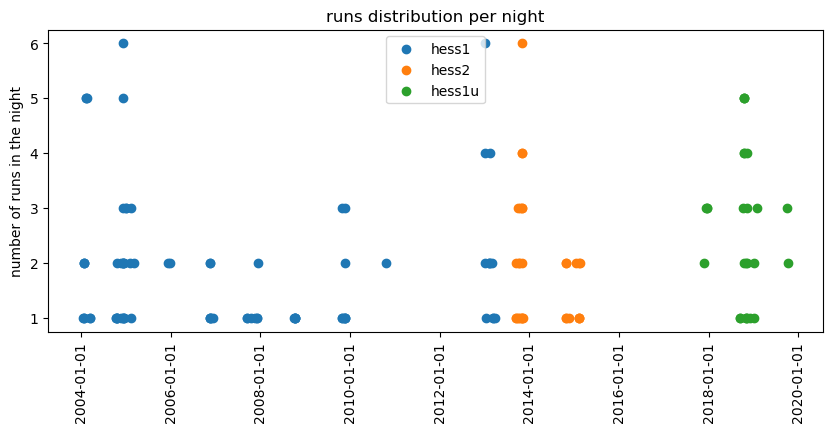

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=100)

for i, table in enumerate(full_info):
    list_date = []
    for date in np.unique(table['DATE-OBS']):
        list_date.append([date, int(np.sum(table['DATE-OBS'] == date))])
    list_date = np.asarray(list_date)
    
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in list_date[:, 0]]
        
    formatter = mdates.DateFormatter("%Y-%m-%d")    
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.YearLocator(2)
    ax.xaxis.set_major_locator(locator)

    ax.scatter(x_values, list_date[:, 1].astype(int), label=hesseras[i])
plt.xticks(rotation=90)
plt.ylabel('number of runs in the night')
plt.title('runs distribution per night')
plt.legend(loc='upper center')
plt.show()

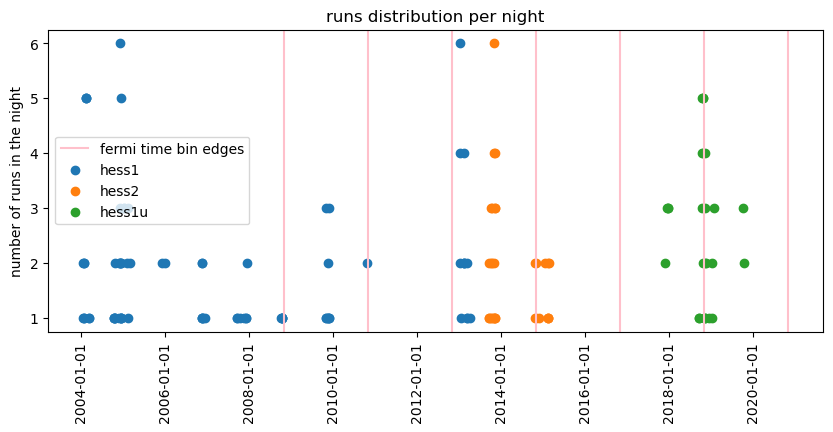

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=100)

for i, table in enumerate(full_info):
    list_date = []
    for date in np.unique(table['DATE-OBS']):
        list_date.append([date, int(np.sum(table['DATE-OBS'] == date))])
    list_date = np.asarray(list_date)
    
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in list_date[:, 0]]
        
    formatter = mdates.DateFormatter("%Y-%m-%d")    
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.YearLocator(2)
    ax.xaxis.set_major_locator(locator)

    ax.scatter(x_values, list_date[:, 1].astype(int), label=hesseras[i])
    
for n_bin_met in range(N_bin_met-1):
    if n_bin_met == N_bin_met-1:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][5:]}-{month}-{day}',"%Y-%m-%d").date()
    else:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][:4]}-{month}-{day}',"%Y-%m-%d").date()
    label = None
    if n_bin_met == 0:
        label='fermi time bin edges'
    ax.axvline(edge, color='pink', label=label)
    
plt.xticks(rotation=90)
plt.ylabel('number of runs in the night')
plt.title('runs distribution per night')
plt.legend()
plt.show()

In [17]:
for idx, hessera in enumerate(hesseras):
    print(f'there are {len(full_info[idx])} runs for {hessera}')

there are 146 runs for hess1
there are 58 runs for hess2
there are 67 runs for hess1u


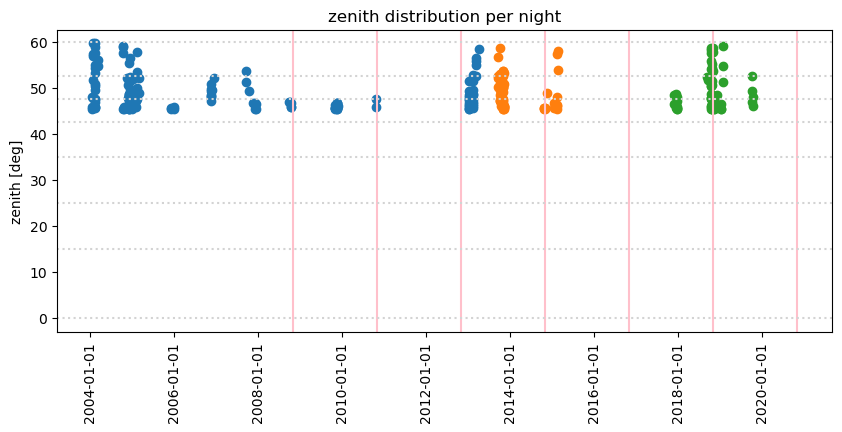

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=100)

for i, table in enumerate(full_info):
    list_date = []
    for j in range(len(table)):
        list_date.append([table['DATE-OBS'][j], table['ZEN_PNT'][j]])
    list_date = np.asarray(list_date)
    
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in list_date[:, 0]]
        
    formatter = mdates.DateFormatter("%Y-%m-%d")    
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.YearLocator(2)
    ax.xaxis.set_major_locator(locator)

    ax.scatter(x_values, list_date[:, 1].astype(float), label=hesseras[i])
    
for n_bin_met in range(N_bin_met-1):
    if n_bin_met == N_bin_met-1:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][5:]}-{month}-{day}',"%Y-%m-%d").date()
    else:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][:4]}-{month}-{day}',"%Y-%m-%d").date()
    label = None
    if n_bin_met == 0:
        label='fermi time bin edges'
    ax.axvline(edge, color='pink', label=label)
    
zen_bins=cfg['zen_bins']
for zen in zen_bins:
    ax.axhline(zen, ls=':', color='lightgray')
plt.xticks(rotation=90)
plt.ylabel('zenith [deg]')
plt.title('zenith distribution per night')
#plt.legend()
plt.show()

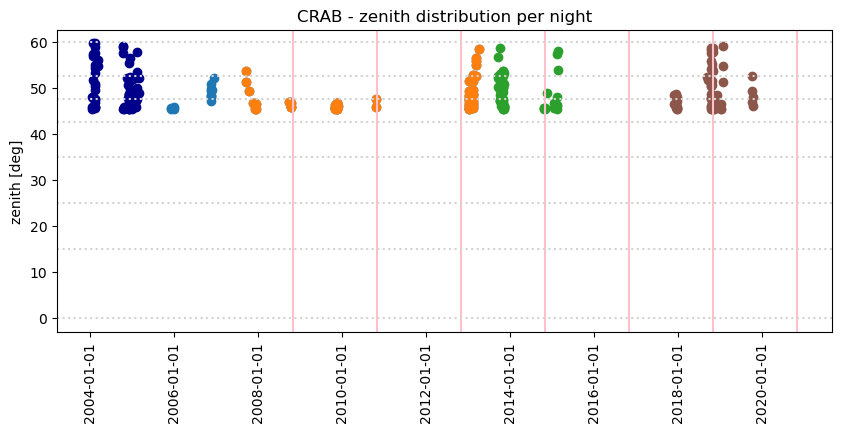

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=100)

color_list = ['darkblue', 'C0', 'C1', 'C2', 'C5']

for i, table in enumerate(full_info):
    list_date = []
    for j in range(len(table)):
        list_date.append([table['DATE-OBS'][j], table['ZEN_PNT'][j]])
    list_date = np.asarray(list_date)
    
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in list_date[:, 0]]
    
    formatter = mdates.DateFormatter("%Y-%m-%d")    
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.YearLocator(2)
    ax.xaxis.set_major_locator(locator)

    if i == 0: 
        date1 = '2005-07-29'
        date2 = '2007-05-16'
        mask1 = [True if d < datetime.datetime.strptime(date1,"%Y-%m-%d").date() else False for d in x_values]
        ax.scatter(np.asarray(x_values)[mask1], list_date[mask1, 1].astype(float), label=hesseras[i], color=f'{color_list[0]}')
        
        mask2_1 = [True if d > datetime.datetime.strptime(date1,"%Y-%m-%d").date() else False for d in x_values]
        mask2_2 = [True if d < datetime.datetime.strptime(date2,"%Y-%m-%d").date() else False for d in x_values]
        mask2 = np.asarray(mask2_1) & np.asarray(mask2_1)        
        ax.scatter(np.asarray(x_values)[mask2], list_date[mask2, 1].astype(float), label=hesseras[i], color=f'{color_list[1]}')
        
        mask3 = [True if d > datetime.datetime.strptime(date2,"%Y-%m-%d").date() else False for d in x_values]        
        ax.scatter(np.asarray(x_values)[mask3], list_date[mask3, 1].astype(float), label=hesseras[i], color=f'{color_list[2]}')
        
        np.savetxt(f'crab_runlist_hess1_0.txt', np.asarray(table['OBS_ID'][mask1]))
        np.savetxt(f'crab_runlist_hess1_1.txt', np.asarray(table['OBS_ID'][mask2]))
        np.savetxt(f'crab_runlist_hess1_2.txt', np.asarray(table['OBS_ID'][mask3]))
    else:
        ax.scatter(x_values, list_date[:, 1].astype(float), label=hesseras[i], color=f'{color_list[i+2]}')
    
    
for n_bin_met in range(N_bin_met-1):
    if n_bin_met == N_bin_met-1:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][5:]}-{month}-{day}',"%Y-%m-%d").date()
    else:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][:4]}-{month}-{day}',"%Y-%m-%d").date()
    label = None
    if n_bin_met == 0:
        label='fermi time bin edges'
    ax.axvline(edge, color='pink', label=label)
    
zen_bins=cfg['zen_bins']
for zen in zen_bins:
    ax.axhline(zen, ls=':', color='lightgray')
plt.xticks(rotation=90)
plt.ylabel('zenith [deg]')
plt.title('CRAB - zenith distribution per night')
#plt.legend()
plt.show()

# creating dataset

In [1]:
import numpy as np
import astropy.units as u
import yaml
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.data import DataStore
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.irf import Background3D

import warnings
warnings.filterwarnings('ignore')

In [2]:
muoneff_flag= True
edisp = True

hessera='hess1u'
if hessera == 'hess1':
    idx_within=2
    full_runlist = np.loadtxt(f'crab_runlist_{hessera}_{idx_within}.txt')
else:
    full_runlist = np.loadtxt(f'crab_runlist_{hessera}.txt')

if hessera =='hess1u':
    muoneff_flag=False

In [3]:
# loading general parameters
with open("/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
repo_path=cfg['repo_path']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']

muoneff_path = cfg['muoneff_path']
model_str = cfg['model_str']
energy_bins = np.logspace(-1, 2, N_ebins+1)

In [4]:
basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
obs_table = ds.obs_table

mask = [True if obsid in full_runlist else False for obsid in obs_table['OBS_ID']]
obs_table=obs_table[mask]

In [5]:
axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
binsz=cfg['binsz']*u.deg
maker = MapDatasetMaker()
if edisp:
    maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'bkg-peak', 'edisp-bias'], offset_max=cfg['offset_cut']*u.deg) 
else:
    maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=cfg['offset_cut']*u.deg)

In [6]:
def create_dataset(runlist, axis, muoneff_flag, background_oversampling=1):
    observations = ds.get_observations(runlist)
    maker = MapDatasetMaker()
    pos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')
    
    geom = WcsGeom.create(skydir=pos, binsz=binsz, width=8, frame="icrs", axes=[axis])
    stacked = MapDataset.create(geom=geom)

    for j, obs in enumerate(observations):
        zen_bin = np.sum(obs.pointing_zen.value > zen_bins) - 1
        
        if muoneff_flag:
            muoneff_path=f'/home/saturn/caph/sn0533/shared/hess/fits/bgmodel_3d/prod05/std_zeta_fullEnclosure/{hessera}/hess1_hess2/v01c_kaori_mueff'
            if obs.obs_info['MUONEFF'] > 0.085:
                model_CD = 'B'
            elif obs.obs_info['MUONEFF'] >= 0.075:
                model_CD = 'D'
            else:
                model_CD = 'C'

            if obs.obs_id >= 100000:
                run_number= f'{obs.obs_id}'
            else:
                run_number= f'0{obs.obs_id}'
            filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
            obs.bkg = Background3D.read(filename, hdu='BACKGROUND')
        
        dataset = stacked.cutout(obs.pointing_radec, width=5)
        dataset = maker.run(dataset, obs)
        
        # this is to set bkg to 0 when it has unreasonable values in the highest energies
        spectrum = np.sum((dataset.background).data, axis=(1,2))
        for i in range(1, 5):
            if spectrum[-1*i] > spectrum[-1*(i+1)]:
                dataset.background.data[-1*i] = 0
        bkg= np.sum((dataset.background).data, axis=(1,2))
        
        dataset = maker_safe_mask.run(dataset, obs)
        
        dataset.mask_fit = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"icrs;circle({pos.ra.deg}, {pos.dec.deg}, 0.4)")
        
        bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
        dataset.models = Models([bkg_model])
        dataset.background_model.spectral_model.tilt.frozen = False
        Fit().run(datasets=[dataset])
                
        if dataset.background_model.spectral_model.norm.value > 0:
            dataset.background.data[~dataset.mask_safe.data] = 0.0
            stacked.stack(dataset)
        else:
            print(f'run: with problem={obs.obs_id}')

    return stacked

In [7]:
%%time
if hessera == 'hess1':
    name = f'20220711_{hessera}_muoneff{muoneff_flag}_edisp{edisp}_{idx_within}.fits'
else:
    name = f'20220711_{hessera}_muoneff{muoneff_flag}_edisp{edisp}.fits'
    
runlist= full_runlist
axis = MapAxis.from_edges(np.logspace(-1,2,25), unit="TeV", name="energy", interp="log")

stacked = create_dataset(runlist, axis, muoneff_flag)
stacked.write(name, overwrite=True)

No HDU found matching: OBS_ID = 135306.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135307.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135479.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135480.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135481.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135629.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135634.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135635.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135665.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135666.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 135667.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 141861.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 141924.0, HDU_TYPE =

CPU times: user 5min 48s, sys: 17.7 s, total: 6min 6s
Wall time: 6min 27s
